In [3]:
from utils import *
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from time import time
from datetime import datetime
import random as rnd
import matplotlib.image as mpimg
rnd.seed(123)

In [8]:
#paths:
celeb_attr = 'list_attr_celeba.csv'
img_database = '../database_20k'
model_path = 'models' # where to save model

### PREPARE DATA FOR TRAINING

In [9]:
# read csv with labels and replase -1 with 0 to get 0/1 labels
df = pd.read_csv(celeb_attr, delimiter = ",")
df = df.replace(-1, 0) 

# there are 40 columns with labels, I selected only few of them to be predicted by model
char = ['Bald','Black_Hair','Blond_Hair','Brown_Hair','Eyeglasses','Gray_Hair',
        'Male','Mustache','No_Beard','Oval_Face','Pale_Skin','Pointy_Nose',
        'Smiling','Straight_Hair','Wavy_Hair','Young', 'Big_Lips', 'Big_Nose']

df = df[['image_id'] + char]
df['Female'] = np.where(df['Male']== 1, 0, 1)
df['Beard'] = np.where(df['No_Beard']== 1, 0, 1)
df['Old'] = np.where(df['Young']== 1, 0, 1)

# drop whole zero rows 
df = df.loc[(df!=0).any(axis=1)]

# drop columns with only one unique value
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)


# The celebA dataset has more than 200k images of celebrities. I decided to select randomly
# 20k of them and use this as main dataset - you can find this 20k images in folder dataset_20k.
path = img_database
img_paths = [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg')]

#img_path_nm = rnd.sample(img_paths, 15000) #full path
img_path_nm = img_paths #full path
img_file_nm = [os.path.basename(f) for f in img_path_nm] #only img names

# get only labes for subset of images
df_sub = df[df['image_id'].isin(img_file_nm)]
labels_np = df_sub.loc[:, df_sub.columns != 'image_id'].to_numpy()

In [58]:
df_sub.head()

image_id  Bald  Black_Hair  Blond_Hair  Brown_Hair  Eyeglasses  \
8   000009.jpg     0           0           0           0           0   
12  000013.jpg     0           0           1           0           0   
15  000016.jpg     0           0           0           0           0   
19  000020.jpg     0           1           0           0           0   
21  000022.jpg     0           0           1           0           0   

    Gray_Hair  Male  Mustache  No_Beard  ...  Pointy_Nose  Smiling  \
8           0     0         0         1  ...            1        1   
12          0     1         0         1  ...            0        1   
15          0     1         0         0  ...            0        1   
19          0     1         0         0  ...            0        0   
21          0     0         0         1  ...            0        0   

    Straight_Hair  Wavy_Hair  Young  Big_Lips  Big_Nose  Female  Beard  Old  
8               0          0      1         1         0       1      0    0  
12              1          0      1         0         0       0      0    0  
15              1          0      1         0         0       0      1    0  
19              0          0      1         0         0       0      1    0  
21              0          1      1         1         0       1      0    0  

[5 rows x 22 columns]

In [59]:
#split data to train, test, valid
train_fn, test_fn, train_lbls, test_lbls = train_test_split(img_path_nm, labels_np, test_size=0.4, random_state=1)
test_fn, valid_fn, test_lbls, valid_lbls = train_test_split(test_fn, test_lbls, test_size=0.5, random_state=1)

In [60]:
train_lbls.shape

(12000, 21)

In [64]:
#create dataset for fine tuning
train_ds = create_dataset(train_fn, train_lbls, batch_size = 256)
test_ds = create_dataset(test_fn, test_lbls, is_training = False, batch_size = 256)
val_ds = create_dataset(valid_fn, valid_lbls, batch_size = 256)

In [65]:
# check dataset
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 21)


### BUILD MODEL

In [67]:
mobileNet = tf.keras.applications.mobilenet.MobileNet()

In [68]:
# Drop last 6 layers and replace last softmax layer with activation sigmoid - due to multi-label classi. 
x = mobileNet.layers[-6].output
output = Dense(units=labels_np.shape[1], activation = 'sigmoid')(x) # If we want to have a classifier to solve a problem with more than one right answer, 
                                                                    # the Sigmoid Function is the right choice.

In [69]:
model = Model(inputs=mobileNet.input, outputs=output)

In [70]:
#retrain only last 23 layers
for layer in model.layers[:-23]:
    layer.trainable = False

### TRAIN MODEL

In [72]:
model.compile(optimizer = Adam(learning_rate=1e-5), loss = tf.keras.metrics.binary_crossentropy, metrics = ['binary_accuracy'])

In [73]:
start = time()

model.fit(x = train_ds, validation_data = val_ds, epochs = 20, verbose = 1)

print('\nTraining took {}'.format((time()-start)))

Epoch 1/20
47/47 [==============================] - 187s 4s/step - loss: 0.6961 - binary_accuracy: 0.5947 - val_loss: 0.9386 - val_binary_accuracy: 0.4798
Epoch 2/20
47/47 [==============================] - 194s 4s/step - loss: 0.5695 - binary_accuracy: 0.7066 - val_loss: 1.0381 - val_binary_accuracy: 0.4997
Epoch 3/20
47/47 [==============================] - 205s 4s/step - loss: 0.4888 - binary_accuracy: 0.7774 - val_loss: 0.9854 - val_binary_accuracy: 0.5242
Epoch 4/20
47/47 [==============================] - 180s 4s/step - loss: 0.4345 - binary_accuracy: 0.8168 - val_loss: 0.8431 - val_binary_accuracy: 0.5669
Epoch 5/20
47/47 [==============================] - 177s 4s/step - loss: 0.3967 - binary_accuracy: 0.8381 - val_loss: 0.6829 - val_binary_accuracy: 0.6306
Epoch 6/20
47/47 [==============================] - 194s 4s/step - loss: 0.3698 - binary_accuracy: 0.8496 - val_loss: 0.5510 - val_binary_accuracy: 0.7055
Epoch 7/20
47/47 [==============================] - 177s 4s/step - los

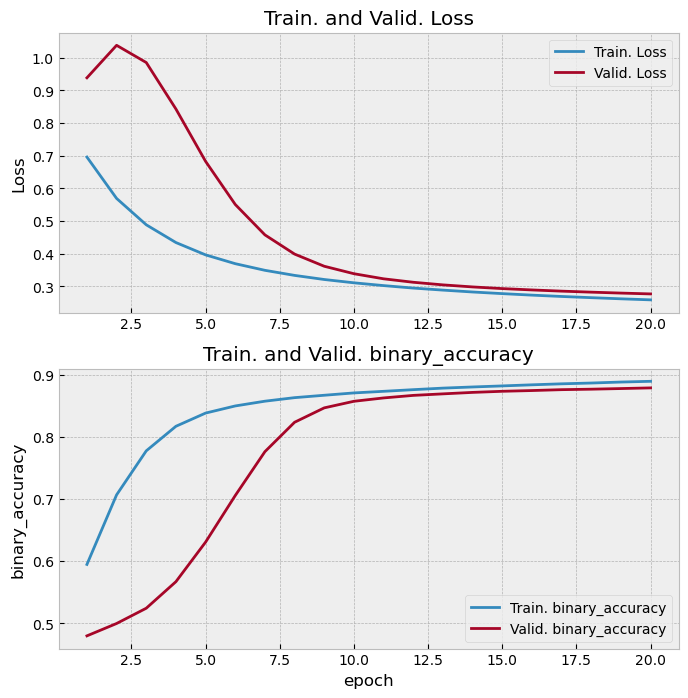

In [75]:
model_losses, model_val_losses, model_acc, model_val_acc = learning_curves(model.history, 'binary_accuracy', 'val_binary_accuracy')

### SAVE MODEL AND CREATE PREDICTIONS

In [76]:
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = model_path +"/fine_tuned_1_{}".format(t)

model.save(export_path) #save your model 

print("Model was exported in this path: '{}'".format(export_path))

INFO:tensorflow:Assets written to: /home/zapletalovama/CBIR/models/fine_tuned_1_20210622_133934/assets
Model was exported in this path: '/home/zapletalovama/CBIR/models/fine_tuned_1_20210622_133934'


In [79]:
#model = tf.keras.models.load_model( 'models/fine_tuned_1_20210622_133934')

In [80]:
def show_prediction(df, imgname, imgname_col, model, path):
    
    # Get movie info
    img_name = df.loc[df[imgname_col]==imgname][imgname_col].iloc[0]
    label = df.loc[df[imgname_col]==imgname, df_sub.columns != imgname_col].to_numpy()
    
    img_path = os.path.join(path, imgname)

    # Read and prepare image
    img = prep_img(img_path, is_tuning=False)
    lbls = label
    
    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = df.columns[1:].to_numpy()
    prediction = prediction[prediction==1].index.values
    
    true_label = pd.Series(label[0])
    true_label.index = df.columns[1:].to_numpy()
    true_label = true_label[true_label==1].index.values

    # Dispaly image with prediction
    style.use('default')
    image = mpimg.imread(img_path)   
    plt.figure(figsize=(8,4))
    plt.imshow(image)
    plt.title('\n\nTrue\n{}\n\nPrediction\n{}\n'.format(true_label, list(prediction)), fontsize=9)
    plt.show()


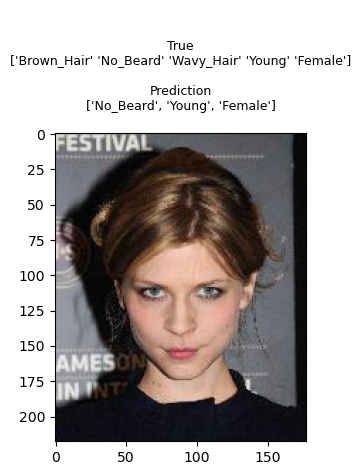

In [88]:
show_prediction(df, os.path.basename(test_fn[155]), 'image_id', 
                model, img_database + '/')